# Preprocessing Data

## Installation Libs

In [27]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Libs

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

## Code

### Useful func

In [29]:
def is_latin(text):
    """ Check if the text contains only Latin characters."""
    return re.match(r'^[\u0000-\u007F\u00A0-\u00FF]+$', text) is not None # ASCII + Latin-1 Supplement

In [30]:
def sanitize_csv_files(input_path):
    """Sanitizes CSV filenames in the specified input_path by renaming them."""
    
    for filename in os.listdir(input_path):
        if filename.endswith('.csv') and filename.startswith('top_50_'):
            
            # Sanitize the filename
            base_name = filename[7:-4]
            country_name = base_name.replace('_', ' ').title()
            new_filename = f"{country_name}.csv"

            # Define the old and new file paths
            old_path = os.path.join(input_path, filename)
            new_path = os.path.join(input_path, new_filename)

            # Rename the file
            os.rename(old_path, new_path)

In [31]:
def data_converter(file_path):
    """Converts the dataset into a more usable format."""
    
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Drop unnecessary column
    df.drop(columns=["album_cover_url"], inplace=True)
    
    # Filter out non-Latin characters
    df = df[df['artist'].apply(is_latin)]
    
    # Convert columns to appropriate data types
    df["date"] = pd.to_datetime(df["date"])
    df["release_date"] = pd.to_datetime(df["release_date"])
    df["is_explicit"] = df["is_explicit"].astype(bool)
    df["duration_sec"] = df["duration_ms"] / 1000
    
    return df

In [32]:
def plot_mean_popularity_per_day(axs, df):
    """Plot the mean popularity per day for a given country."""
    
    # Plot the mean popularity per day
    df.groupby("date")["popularity"].mean().plot(ax=axs[0, 0], 
                                                 color="darkorange", 
                                                 linewidth=1.3,
                                                 marker=",", 
                                                 markersize=0.5)
    # Set parameters for the plot
    axs[0, 0].set_title("Mean Popularity per Day")
    axs[0, 0].set_xlabel("Date")
    axs[0, 0].set_ylabel("Popularity")
    axs[0, 0].tick_params(axis='x', rotation=45)
    axs[0, 0].grid(True)
    
    return axs [0, 0]

In [33]:
def plot_duration_distribution(axs, df):
    """Plot the distribution of song durations for a given country."""
    
    # Plot the distribution of song durations
    sns.histplot(df["duration_sec"], 
                    bins=30, 
                    kde=True, 
                    ax=axs[0, 1], 
                    color="darkblue",
                    edgecolor="black", 
                    alpha=0.6)
    
    # Set parameters for the plot
    axs[0, 1].set_title("Duration Distribution")
    axs[0, 1].set_xlabel("Duration (seconds)")
    axs[0, 1].set_ylabel("Frequency")
    axs[0, 1].grid(True)
    
    return axs[0,1]

In [34]:
def plot_explicit_vs_non_explicit(axs, df):
    """Plot the distribution of explicit vs non-explicit songs for a given country."""
    
    # Plot the distribution of explicit vs non-explicit songs
    sns.countplot(x="is_explicit", 
                    data=df, 
                    ax=axs[1, 0], 
                    palette=["lightgreen", "lightcoral"], 
                    alpha=1.0)
    
    # Set parameters for the plot
    axs[1, 0].set_title("Explicit vs Non-Explicit")
    axs[1, 0].set_xlabel("Is Explicit")
    axs[1, 0].set_ylabel("Count")
    axs[1, 0].set_xticklabels(["Non-Explicit", "Explicit"])
    
    return axs[1, 0]

In [35]:
def plot_top_artists(axs, df):
    """Plot the top artist in each popularity bin (step 10)."""
    
    # Calculate the mean popularity for each artist
    mean_popularity = df.groupby("artist")["popularity"].mean()

    # Define the bins and labels
    bins = list(range(10, 101, 10))
    labels = [f"{i}-{i+9}" for i in bins[:-1]]
    labels[-1] = "90-100"  # Include il 100 nel bin finale

    # Bins Values
    binned = pd.cut(mean_popularity, bins=bins, labels=labels, right=True, include_lowest=True)

    # Combine all in un DataFrame
    binned_df = pd.DataFrame({
        "artist": mean_popularity.index,
        "mean_popularity": mean_popularity.values,
        "pop_bin": binned
    })

    # Order the DataFrame by mean popularity
    top_per_bin = (
        binned_df
        .sort_values("mean_popularity", ascending=False)
        .groupby("pop_bin")
        .first()
        .dropna(subset=["artist", "mean_popularity"])
    )

    # Create the barplot
    bars = axs[1, 1].bar(top_per_bin.index, top_per_bin["mean_popularity"],
                         color=sns.color_palette("viridis", n_colors=len(top_per_bin)))

    # Labels for each bar
    for bar, artist in zip(bars, top_per_bin["artist"]):
        label = artist[:12] + ("…" if len(artist) > 12 else "")
        axs[1, 1].text(bar.get_x() + bar.get_width() / 2,
                       bar.get_height() + 1,
                       label,
                       ha='center', va='center_baseline', fontsize=10)

    # Title and labels
    axs[1, 1].set_title("Top Artists per Bins per Mean Popularity")
    axs[1, 1].set_xlabel("Mean Popularity")
    axs[1, 1].set_ylabel("Bins Mean Popularity")
    axs[1, 1].tick_params(axis='x', rotation=45)

    return axs[1, 1]


In [36]:
def logging(df, log_path, country_name):
    """Log the dataset information and statistics."""
    
    log_file = os.path.join(log_path, f"{country_name}_stats.txt") # Define log file path
    
    # Inject the dataset information into the log file
    with open(log_file, 'w') as log:
        log.write(f"Analyzing {country_name} dataset...\n")
        log.write(f"First few rows:\n{df.head()}\n")
        log.write(f"Dataset statistics:\n{df.describe()}\n")

### Exec Analysis

In [37]:
def analyze_country(axs, file_path, country_name, results_path, log_path):
    """Analyze the dataset for a specific country."""
    
    df = data_converter(file_path) # Convert the dataset
    logging(df, log_path, country_name) # Log the dataset information
        
    # Plotting
    axs[0,0] = plot_mean_popularity_per_day(axs, df)
    axs[0, 1] = plot_duration_distribution(axs, df)
    axs[1, 0] = plot_explicit_vs_non_explicit(axs, df)
    axs[1, 1] = plot_top_artists(axs, df)
    
    # Save the figure
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    output_path = os.path.join(results_path, f"{country_name}_summary.png")
    plt.savefig(output_path)
    plt.show()

In [38]:
input_path = "../data" # Input Data Path
sanitize_csv_files(input_path) # Sanitize CSV filenames
all_files = [f for f in os.listdir(input_path) if f.endswith(".csv")] # Get all CSV files

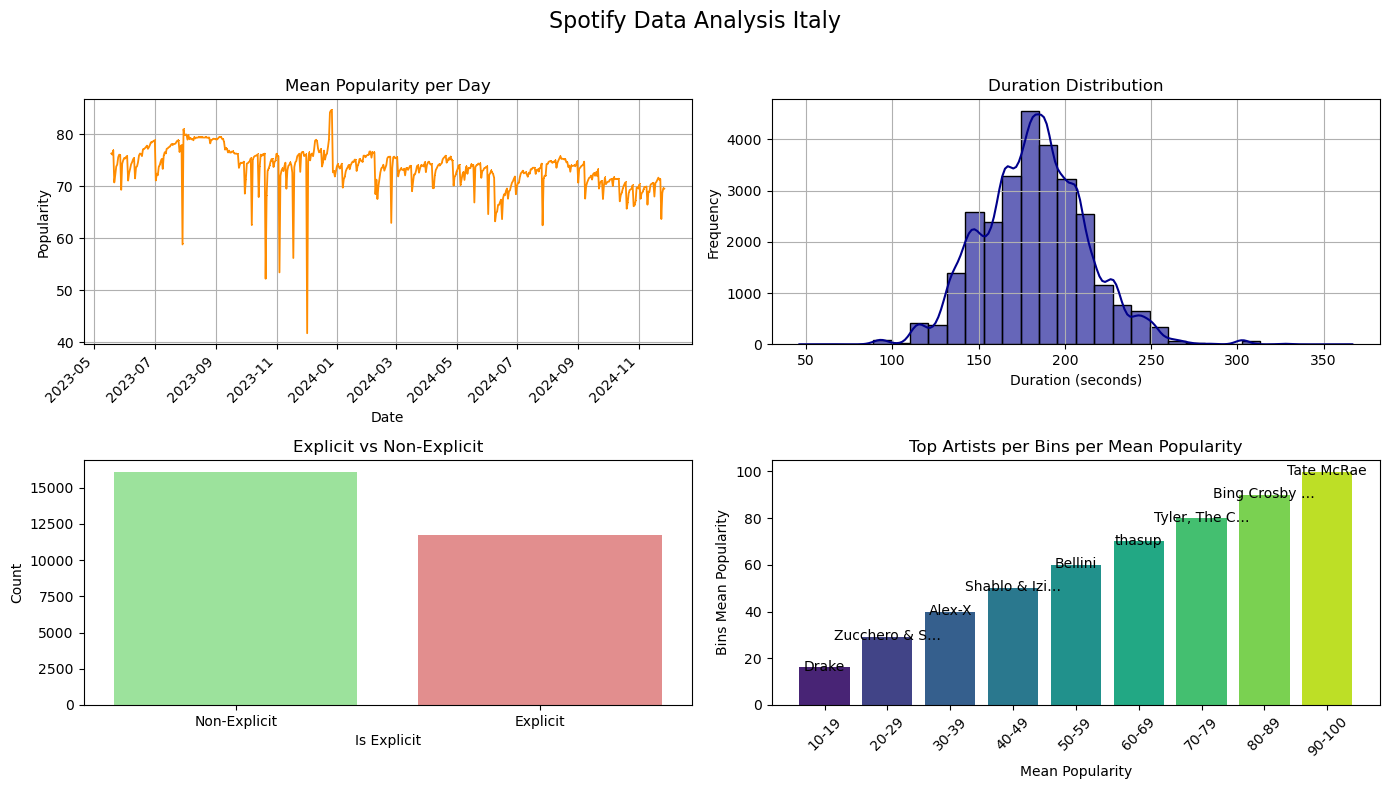

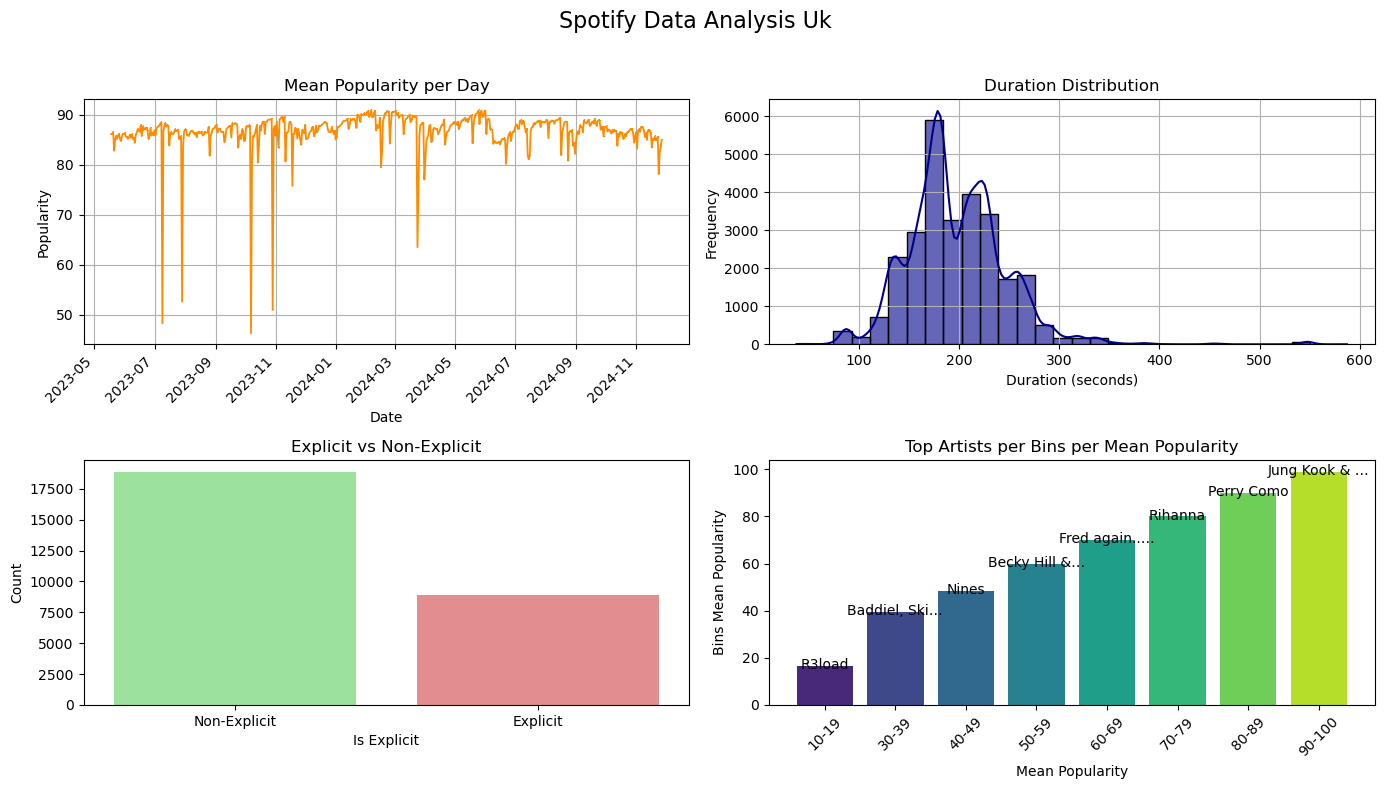

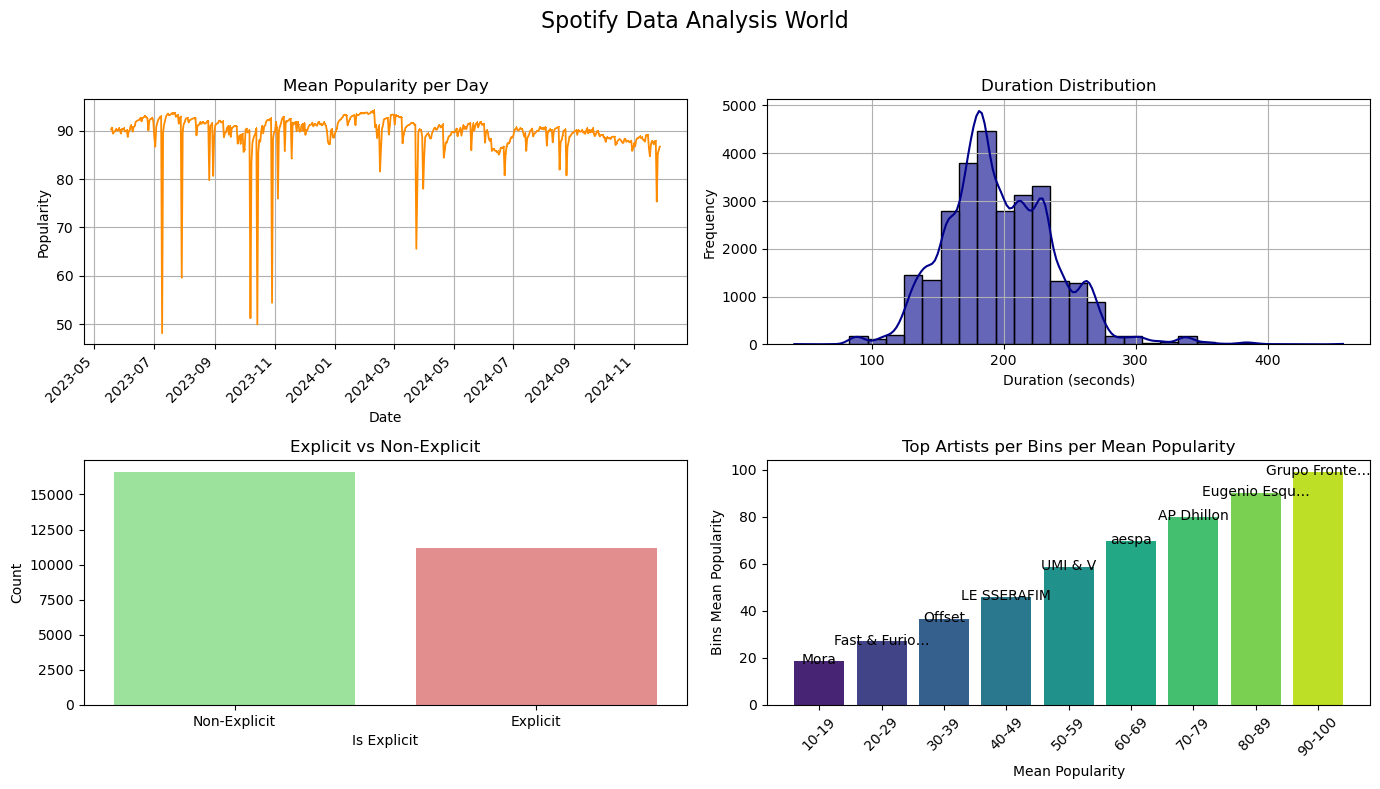

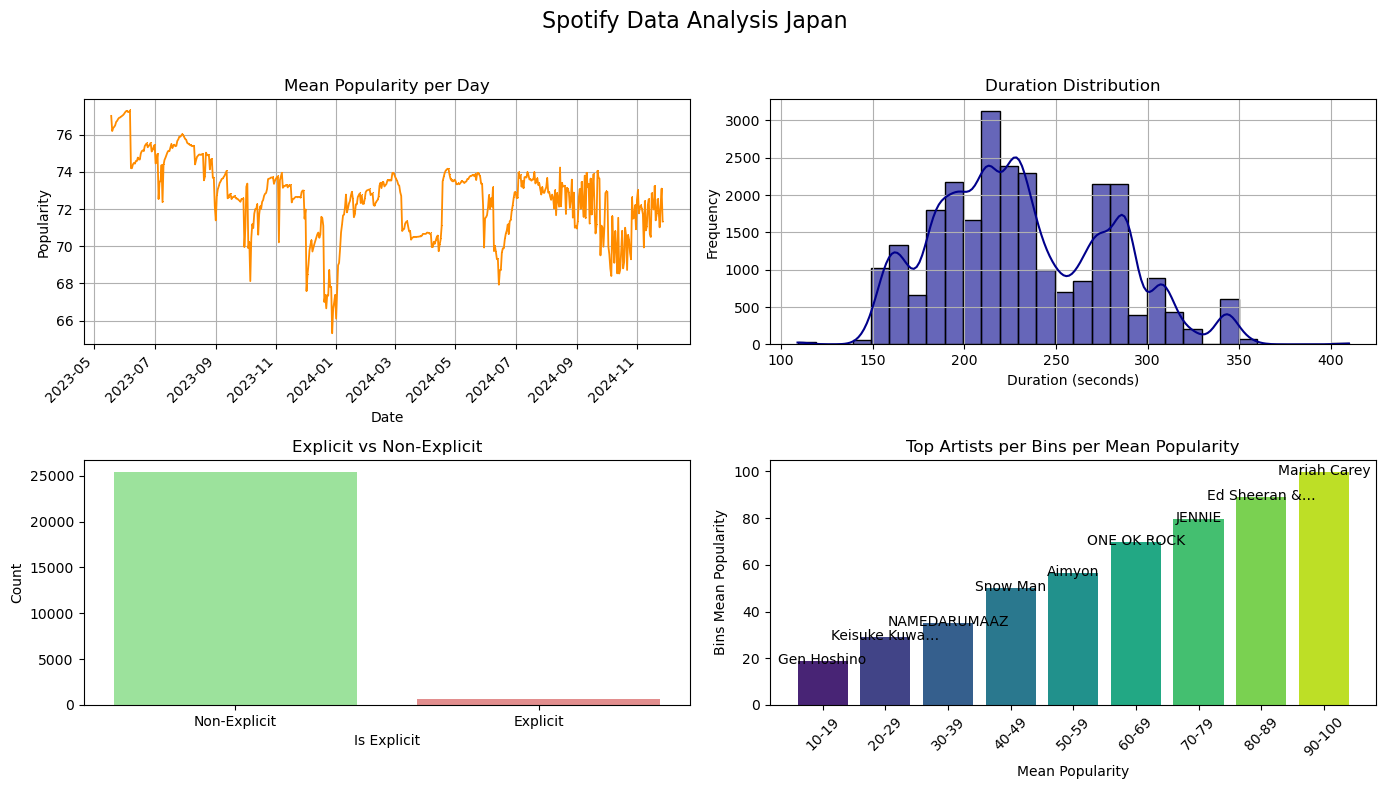

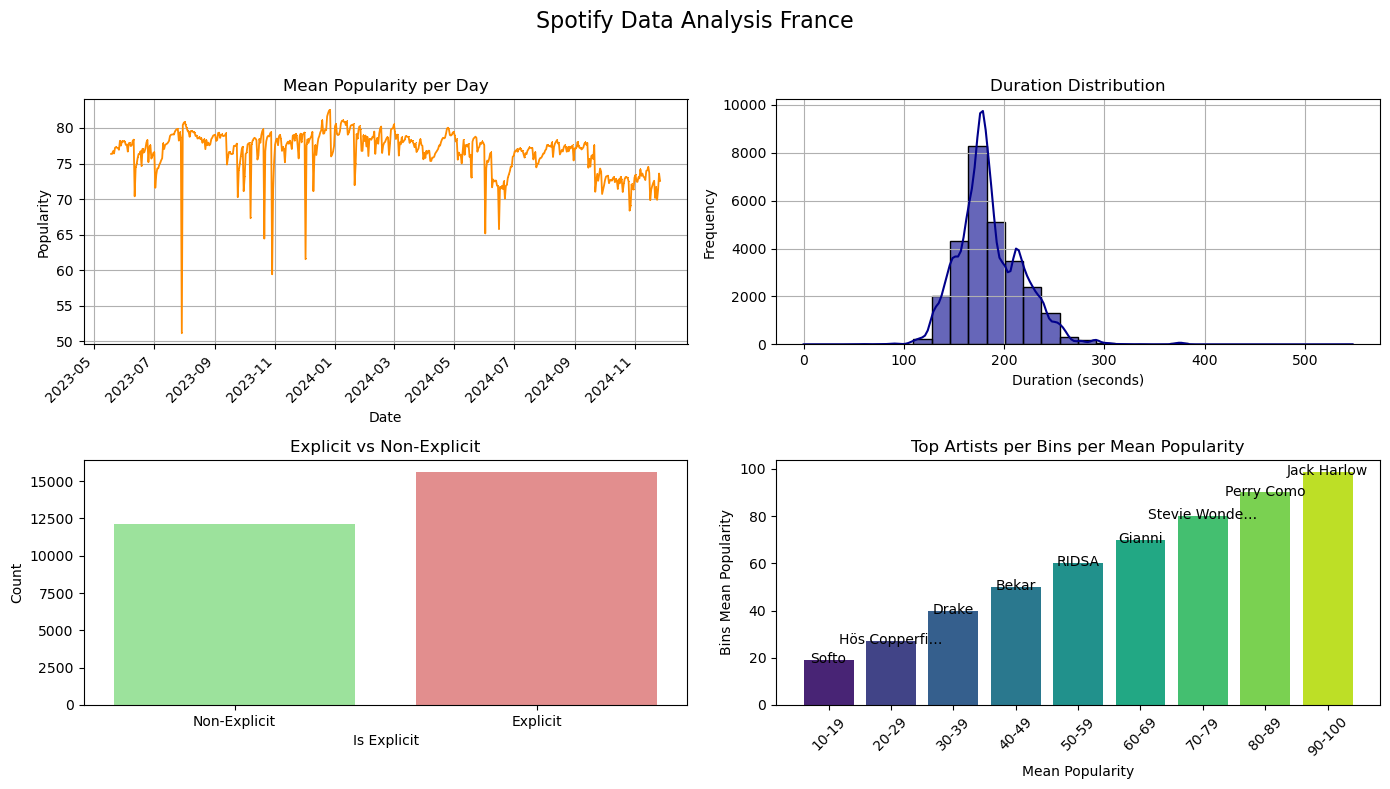

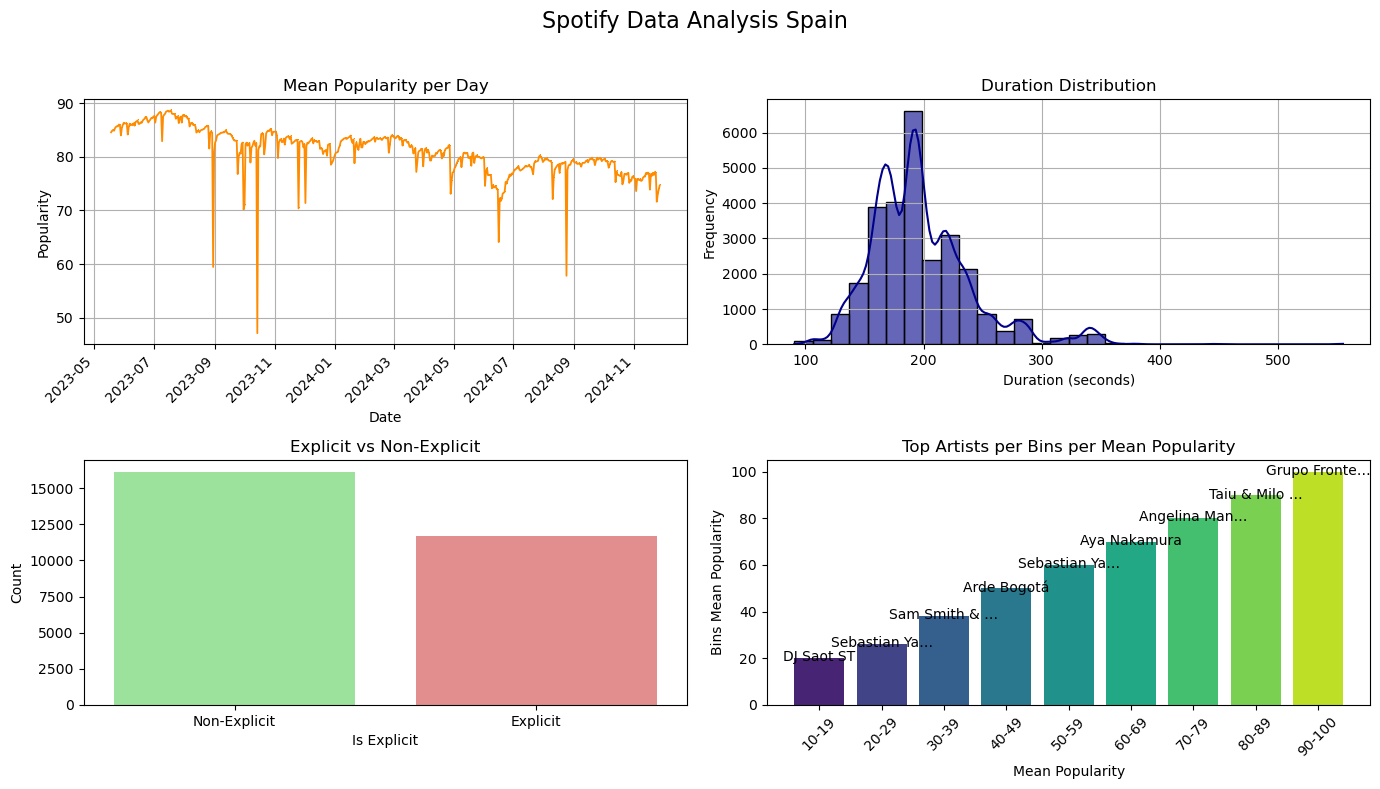

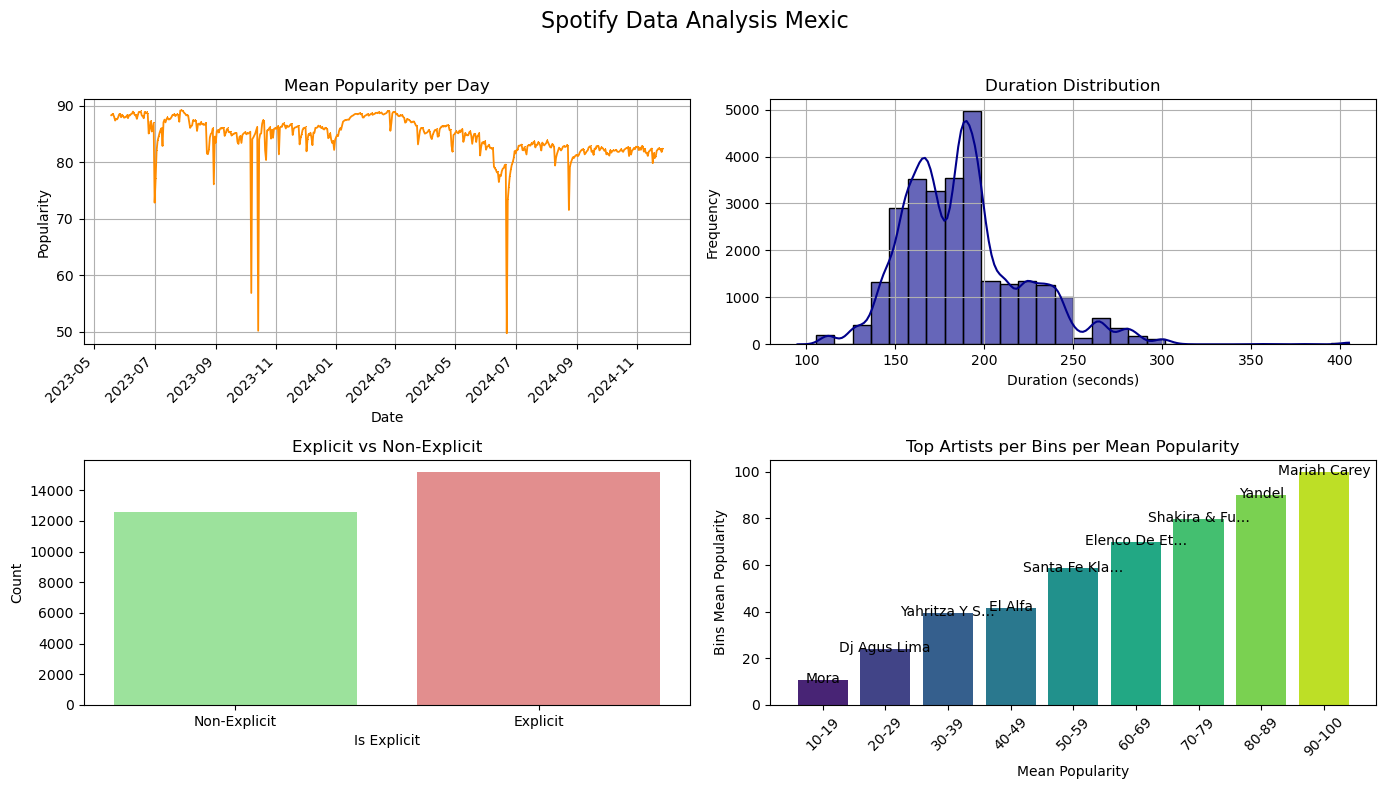

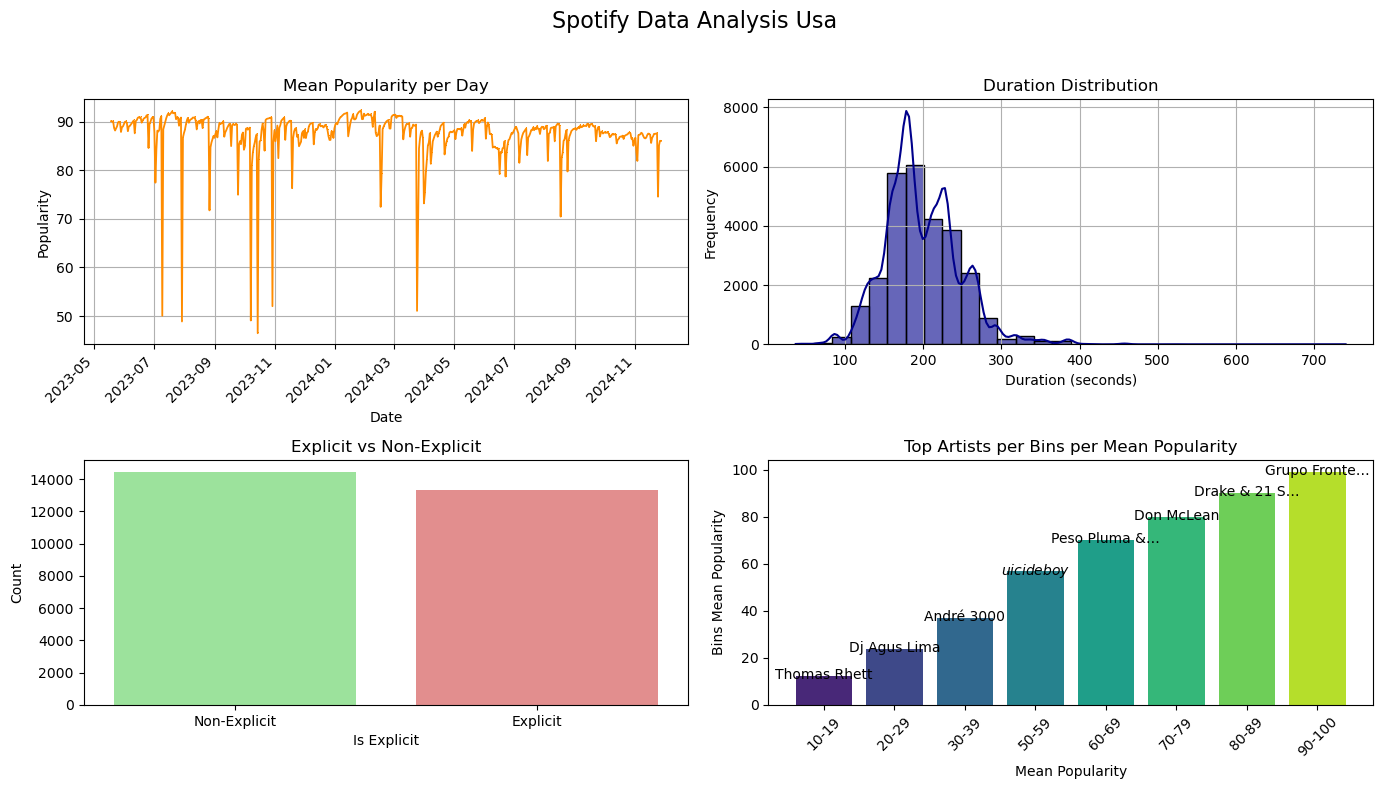

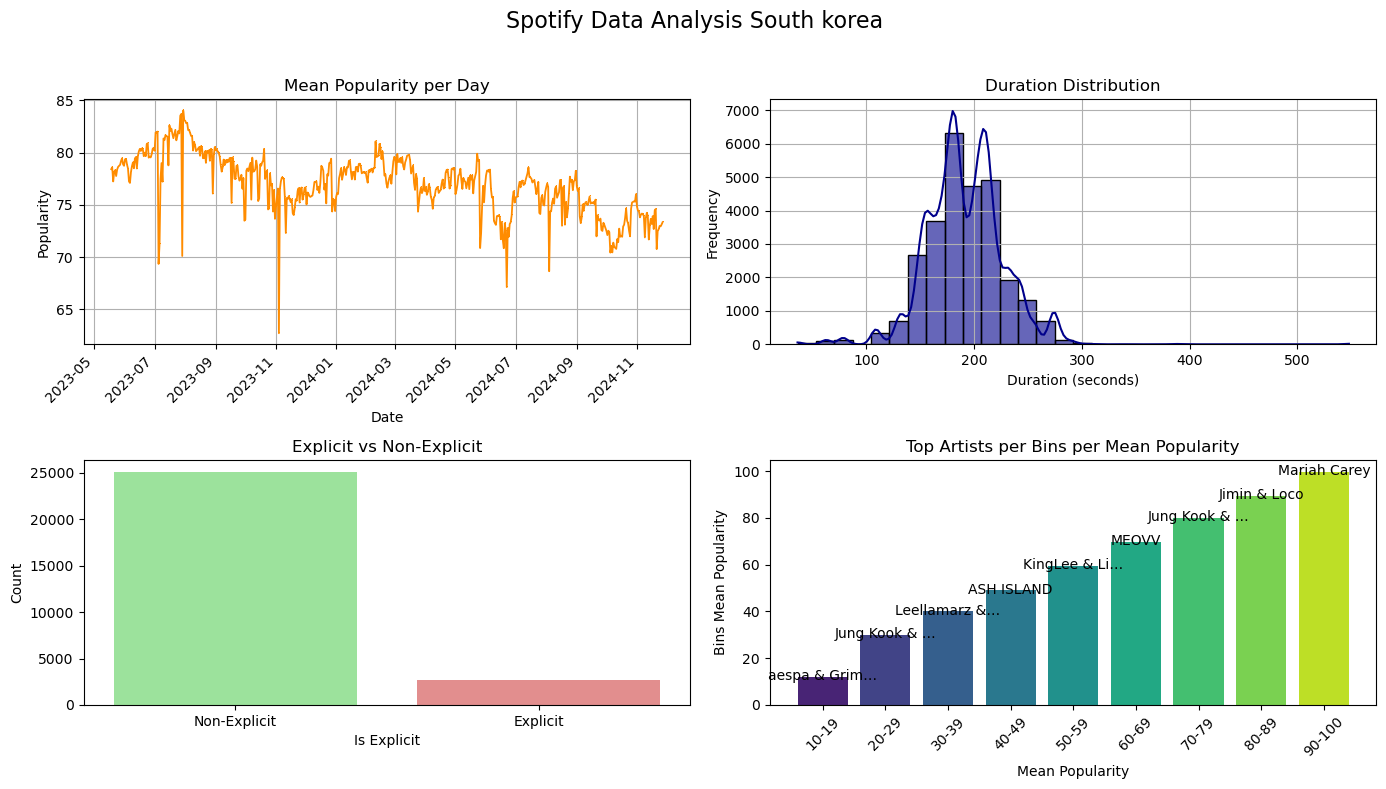

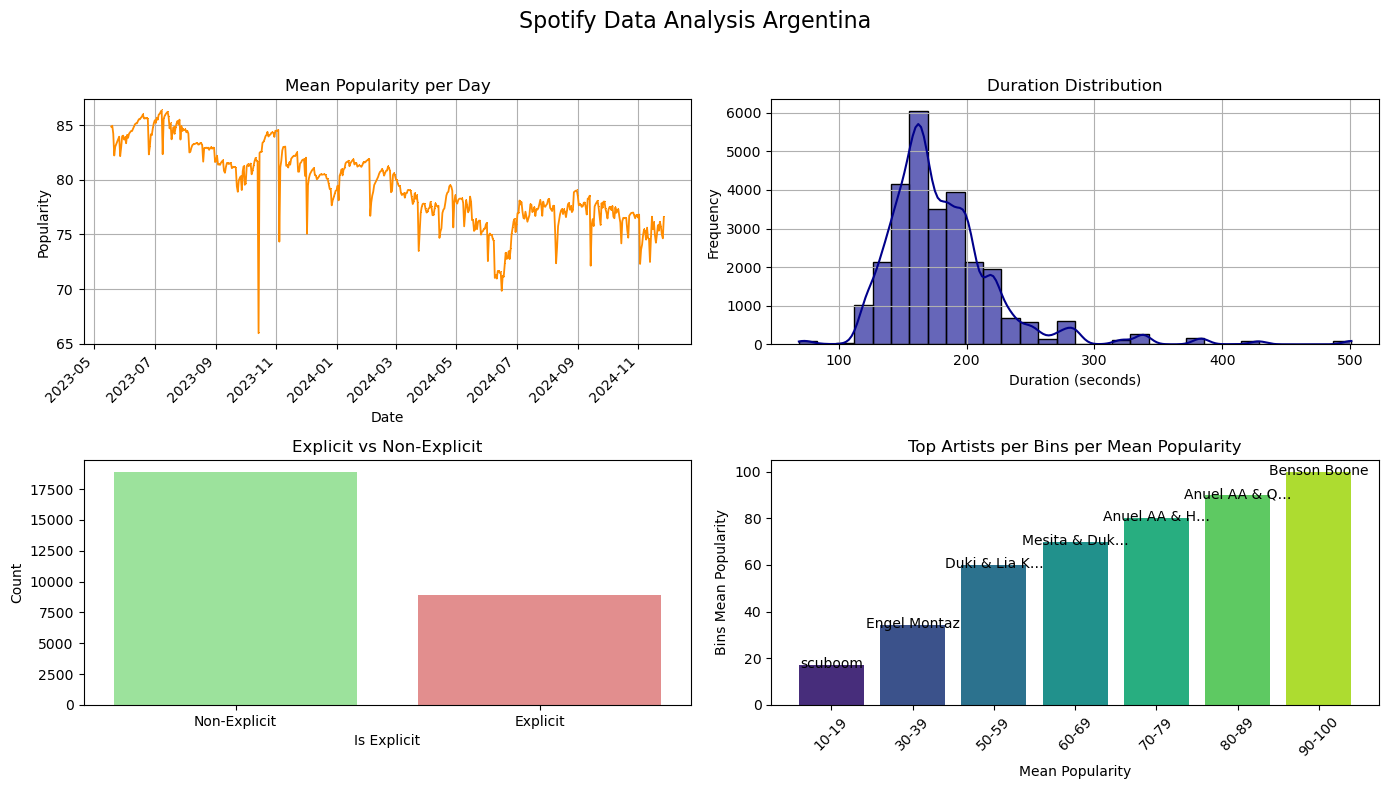

In [39]:
results_path = "../img" # Results Path
log_path = "../log" # Log Path

# Create results and log directories if they don't exist
if not os.path.exists(results_path):
    os.makedirs(results_path)
if not os.path.exists(log_path):
    os.makedirs(log_path)

# Loop through all files and analyze each country
for file in all_files:
    country_name = os.path.splitext(file)[0].capitalize() # Get country name
    file_path = os.path.join(input_path, file) # Define file path
    
    # Plot Settings
    fig, axs = plt.subplots(2, 2, figsize=(14, 8))
    fig.suptitle(f'Spotify Data Analysis {country_name}', fontsize=16)
    
    # Analize the country
    analyze_country(axs, file_path, country_name, results_path, log_path)